# Discovery Process

Let Start With some basics, provided data have only three fields of data a timestamp, travel distance and travel time. The dataset is huge, so I hope it would not be a problem to process.

Let start with simple counts to have clear picture about travel parameters

In [47]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

#df = pd.read_csv('test.csv')
df = pd.read_csv('test.csv', dtype={"Date/Time": object, "Travel Distance": np.int64, "Travel duration": np.int64})
df.columns = ['date', 't_d', 't_t']
#df.t_d.astype(np.int64)
#df.t_t.astype(np.int64)

<Container object of 87 artists>

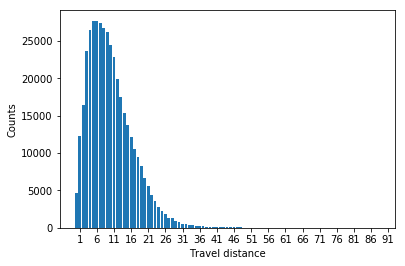

In [48]:
x = df.t_d.value_counts()
plt.xticks(np.arange(min(x), max(x)+1, 5.0))
plt.xlabel('Travel distance')
plt.ylabel('Counts')
plt.bar(x.index.values, x)

In [49]:
np.mean(df.t_d)

10.075625890544439

There are 2 things to notice here
   - The mean rides are of almost 10 units of distance
   - The counts of provided data is forming a normal bell curve providing us intitution of normal distribution
   - This information can be useful to find fraud detection as rides outside the 2nd standard deviation are outlier and should be investigate

<Container object of 171 artists>

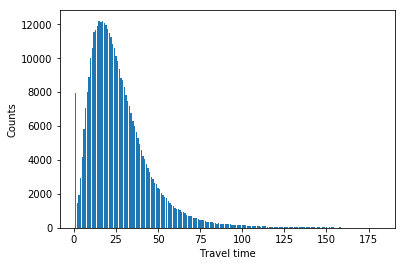

In [61]:
q = df.t_t.value_counts()
# Filtering value counts greater than 10 to get a visible graph
q = q.loc[q > 10]
plt.xlabel('Travel time')
plt.ylabel('Counts')
plt.bar(q.index.values, q)
#q.plot.bar()

In [62]:
np.mean(df.t_t)

28.833623040802237

Same discovery points of travel distance is aplicable here, just the mean time is almost **29** units

In [63]:
from datetime import datetime
firstDate = datetime.strptime(df.date[8728], '%m/%d/%Y %H:%M:%S')
lastDate = datetime.strptime(df.date.iloc[-1], '%m/%d/%Y %H:%M:%S')

diff = lastDate - firstDate
print("Days {}".format(diff.days))

Days 57


Provided data is collected over **57** days.

Now lets find out max values of our parameters

In [64]:
df.t_d.max()

88

In [65]:
df.t_t.max()

156241

So, the the max travel distace is 88 units and 156241 units travel time. Let find the rows for the max values

In [66]:
df.t_d[88]

7

In [67]:
df.loc[df['t_d'] == 88]

,date,t_d,t_t
198194,12/29/2018 00:01:55,88,220


In [68]:
df.loc[df['t_t'] == 156241]

,date,t_d,t_t
359705,01/20/2019 22:23:22,8,156241


So appreantly there are only one entries for both max values. But, what we have catch here, a bad fish in a pound. Isn't odd that 88 units of distance is covered in 220 units of time and only 8 unit of distance is covered in **156241** time???

Let check the releation ship between travel distance and travel time, but first let normalize the data to relax load on my CPU.

In [69]:
nor_df = df.copy()
nor_df['t_d'] = nor_df['t_d']/88
nor_df['t_t'] = nor_df['t_t']/156241
nor_df.head()

,date,t_d,t_t
0,12/31/2018 00:00:16,0.090909,0.000109
1,12/31/2018 00:01:03,0.090909,0.000122
2,12/31/2018 00:02:49,0.125000,0.000250
3,12/31/2018 00:03:09,0.125000,0.000122
4,12/31/2018 00:04:01,0.102273,0.000070


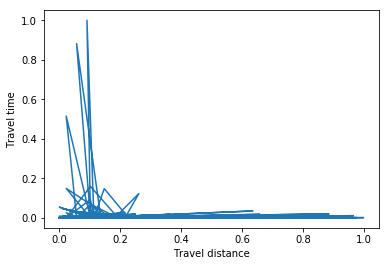

In [70]:
plt.plot(nor_df['t_d'], nor_df['t_t'])
plt.xlabel('Travel distance')
plt.ylabel('Travel time')
plt.show()

Gotcha!!!

Here, we can see clearly that most of the rides are completed within 0.2 normailzed unit of travel time. And there are some outliers which are covered in expectinonaly high values of time.

Lets catch them!!!

In [71]:
nor_df.loc[nor_df['t_t']> 0.2]

,date,t_d,t_t
225239,01/02/2019 10:42:05,0.022727,0.515383
356505,01/20/2019 09:28:55,0.056818,0.881792
359705,01/20/2019 22:23:22,0.090909,1.000000


Here we got our extreem outliers, these rides should be investigated and flaged for fraud. 
Now if we remove outliers from our data we can see the linearity of the data

In [72]:
nor_df.loc[225239]

date    01/02/2019 10:42:05
t_d               0.0227273
t_t                0.515383
Name: 225239, dtype: object

In [73]:
tmp = nor_df.copy()
ind = nor_df.loc[nor_df['t_t']> 0.2].index
tmp.drop(ind,inplace=True)

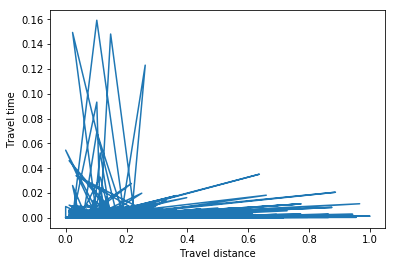

In [74]:
plt.plot(tmp['t_d'], tmp['t_t'])
plt.xlabel('Travel distance')
plt.ylabel('Travel time')
plt.show()

Now we can see that there are still some outliers left, and can be filter out

In [75]:
print(tmp.loc[tmp['t_t'] > 0.02])

                       date       t_d       t_t
14516   12/02/2018 12:36:34  0.147727  0.148085
21347   12/03/2018 17:35:25  0.102273  0.159190
109553  12/15/2018 18:37:45  0.011364  0.046127
112812  12/16/2018 13:35:44  0.022727  0.149353
118159  12/17/2018 13:35:14  0.113636  0.022619
128475  12/18/2018 19:25:41  0.261364  0.123021
146707  12/21/2018 09:31:40  0.034091  0.033986
184460  12/27/2018 09:51:17  0.022727  0.026088
198340  12/29/2018 01:24:50  0.102273  0.068977
198497  12/29/2018 08:19:56  0.113636  0.032815
200217  12/29/2018 13:24:25  0.102273  0.093253
218722  01/01/2019 12:10:09  0.113636  0.052317
326253  01/16/2019 11:22:12  0.215909  0.027739
369777  01/22/2019 17:08:42  0.000000  0.054563
375894  01/23/2019 13:44:49  0.636364  0.035208
402307  01/26/2019 19:06:44  0.886364  0.020680


Above are the rides which are found to be moderately outliers which should also be investigated, but with less restictions. Now by removing these values we can get our linear graph

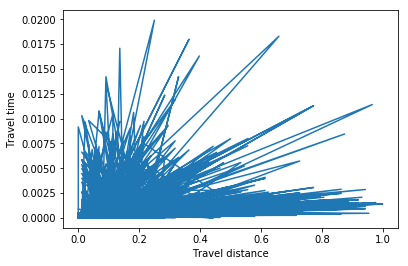

In [76]:
tmp = tmp.loc[tmp['t_t'] < 0.02]
plt.plot(tmp['t_d'], tmp['t_t'])
plt.xlabel('Travel distance')
plt.ylabel('Travel time')
plt.show()

And here it is!!!

8481.835725206443


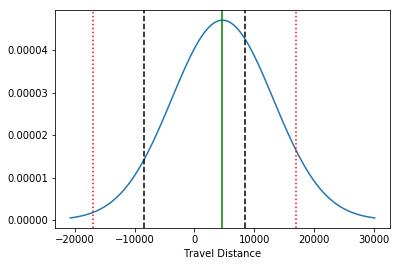

In [78]:
import math
import matplotlib.mlab as mlab

td_counts = df.t_d.value_counts()
#td_counts = df.t_d

mu = np.mean(td_counts)
variance = np.var(td_counts)
sigma = math.sqrt(variance)
print(sigma)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#plt.xticks(np.arange(-3*sigma, 3*sigma, step=5))
plt.xlabel("Travel Distance")
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.axvline(x=mu, color='g')
plt.axvline(x=sigma, color='k', linestyle='--')
plt.axvline(x=-sigma, color='k', linestyle='--')
plt.axvline(x=2*sigma, color='r', linestyle=':')
plt.axvline(x=-2*sigma, color='r', linestyle=':')
plt.show()

So, simply to find fraudulent rides w.r.t to Travel distance group counts you can refer above graph. Anything above red dotted lines have high chances of fraudulent ride, anything above black doted line need to be observe

Now lets group data with respect to days

In [79]:
gp = df['date'].copy()
mapper = {0:gp[0].split(" ")[0]}
marker = 0
prev = ''
for idx, value in gp.iteritems():
    date = value.split(" ")[0]
    if prev != date:
        marker+=1
        mapper.update({marker:date})
        prev = date
    
    gp[idx] = marker

df_gp = df.copy()
df_gp['date'] = gp

<Container object of 59 artists>

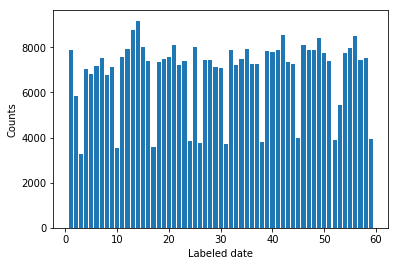

In [81]:
x = df_gp.date.value_counts()
#plt.xticks(np.arange(min(x), max(x)+1, 1))
plt.xlabel('Labeled date')
plt.ylabel('Counts')
plt.bar(x.index.values, x)

In [82]:
x.loc[x == x.max()]
print("Max rides is dated on {}".format(mapper[x.index[0]]))

Max rides is dated on 12/13/2018


Max rides is dated on **12/13/2018**

Here we see a pattern that on some days of the week there are less rides than other, let filter them out

In [9]:
x.loc[x<4000]
print('Follwing dates have less than 4000 rides')
for idx in x.loc[x<4000].index:
    print(mapper[idx])

Follwing dates have less than 4000 rides
01/27/2019
01/20/2019
12/23/2018
01/06/2019
12/25/2018
12/30/2018
12/16/2018
12/09/2018
12/02/2018


Now lets check howmany of them are in weekends

In [15]:
for idx in x.loc[x<4000].index:
    date = datetime.strptime(mapper[idx], '%m/%d/%Y')
    weekno = date.weekday()
    
    if weekno<5:
        print("{} is a Weekday".format(date))
    else:
        print("{} is a Weekend".format(date))

2019-01-27 00:00:00 is a Weekend
2019-01-20 00:00:00 is a Weekend
2018-12-23 00:00:00 is a Weekend
2019-01-06 00:00:00 is a Weekend
2018-12-25 00:00:00 is a Weekday
2018-12-30 00:00:00 is a Weekend
2018-12-16 00:00:00 is a Weekend
2018-12-09 00:00:00 is a Weekend
2018-12-02 00:00:00 is a Weekend


And as expected all dates were weekend expect **2018-12-25**, but yet again it was Christmas/Muhammah Ali Jinnah Birthday which was a holiday. So we can safel deduce that rides are taken less on holidays.

Till here I deduced many things which can be printed on jypyter at it is, But I want to show you a little gist of what more can a viz wizard can do....

In [46]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly


x = []
df_day = df_gp.loc[df_gp['date']<8]

for col in df_day.columns.values:
    if col in ['date']:
        x.append(dict(label=col, tickvals=[1,2,3,4,5,6,7], ticktext=[mapper[x] for x in range(1, 8)], values=df_day[col]))
    else:
        x.append(dict(label=col, values=df_day[col]))
    
data = [
    go.Parcoords(
        dimensions=x,
    )
]

layout = go.Layout(
    plot_bgcolor = '#E5E5E5',
    paper_bgcolor = '#E5E5E5'
)

fig = go.Figure(data = data, layout = layout)
plotly.offline.plot(fig)

'file:///home/oak/Documents/Bykea/temp-plot.html'

I hope that would be enough for a given dataset. I produced two images from above tool, please check them in the repository.

Please use "temp-plot.html" to use above produced tool.

Oak logging out!